In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter
from skimage.transform import resize
from sklearn.decomposition import PCA
import cv2
import os
import xml.etree.ElementTree as ET

In [2]:
!pip install spectral
from spectral import *

# Visualizing the Cassis filters

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def read_response_filters():
     # read CaSSIS filter
    response_filter_blue = pd.read_csv('../response_filter/normalized_response_BLU.TXT', delim_whitespace=True, header=None)
    response_filter_nir = pd.read_csv('../response_filter/normalized_response_NIR.TXT', delim_whitespace=True, header=None)
    response_filter_pan = pd.read_csv('../response_filter/normalized_response_PAN.TXT', delim_whitespace=True, header=None)
    response_filter_red = pd.read_csv('../response_filter/normalized_response_RED.TXT', delim_whitespace=True, header=None)
    dat= {'wavelength': response_filter_blue.iloc[:,0]
          , 'blue': response_filter_blue.iloc[:,1]
          ,'pan': response_filter_pan.iloc[:,1],
          'nir': response_filter_nir.iloc[:,1],
          "red": response_filter_red.iloc[:,1]}
    Response_filters = pd.DataFrame(data= dat)
    return Response_filters


In [6]:
Response_filters = read_response_filters()
Response_filters

,wavelength,blue,pan,nir,red
0,350.0,0.000000,0.000000,0.000003,0.000000
1,351.0,0.000000,0.000000,0.000000,0.000000
2,352.0,0.000000,0.000000,0.000000,0.000000
3,353.0,0.000000,0.000000,0.000000,0.000000
4,354.0,0.000007,0.000000,0.000002,0.000000
...,...,...,...,...,...
746,1096.0,0.000083,0.000002,0.039262,0.000015
747,1097.0,0.000101,0.000002,0.038193,0.000013
748,1098.0,0.000127,0.000003,0.037237,0.000015
749,1099.0,0.000164,0.000003,0.036234,0.000015


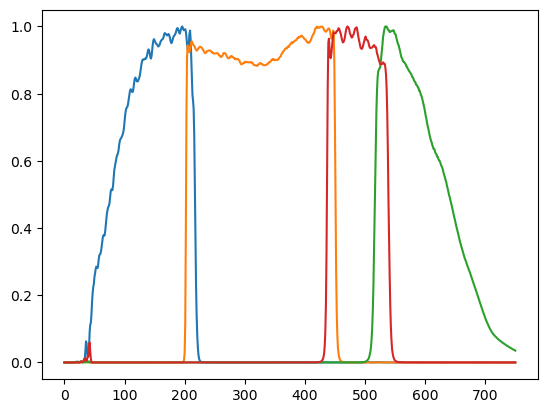

In [ ]:
plt.plot(Response_filters[["blue","pan","nir","red"]])

# Applying filters to CRISM Images

## Creating Pan Nir Red dataset

In [8]:
def createInputImage(path):
    # read CRISM spectral cube
    filename_hdr = path
    #read hdr file

    #import datasets
    img = envi.open(filename_hdr)

    #wavelength
    wavelength = np.array(list(map(int,img.bands.centers)))
    print("Number of Bands: " , wavelength.shape[0])

    #load spectral data as image.array.
    data_spectral = img.load()
    print("Shape of spectral data cube: ", data_spectral.shape)

    assert wavelength.shape[0]==data_spectral.shape[2]
    print(type(data_spectral))
    arr = np.array(data_spectral)
    print(type(arr))
    image_size = data_spectral.shape[0]*data_spectral.shape[1]
    image_width = data_spectral.shape[0]
    image_height = data_spectral.shape[1]

    # show band 40 of spectral cube
    slice_data = arr[:,:,40]

    slice_data[slice_data==65535]=np.nan

    # apply filters on CRISM spectral cube to convert it to CaSSIS 4 features (red,blue,pan,nir)

    images_products = pd.DataFrame(data=np.zeros((image_size,4)),columns =("cassis_blue","cassis_pan",
                                                                          "cassis_nir","cassis_red") )
    spectra_cube = pd.DataFrame(data=np.reshape(arr,(image_size,-1)),columns=wavelength)


    filter1=[]
    filter2=[]
    filter3=[]
    filter4=[]
    wavelengths =Response_filters["wavelength"]
    for columns in spectra_cube.columns:
        wv = float((int(float((columns)))))
        if wv<1101:
            pos= wavelengths[wavelengths == wv].index[0]
            filter1.append(Response_filters.loc[pos,"blue"])
            filter2.append(Response_filters.loc[pos,"pan"])
            filter3.append(Response_filters.loc[pos,"nir"])
            filter4.append(Response_filters.loc[pos,"red"])
        else:
            filter1.append(0.0)
            filter2.append(0.0)
            filter3.append(0.0)
            filter4.append(0.0)
    i=0
    for iter, rows in spectra_cube.iterrows():
         images_products.at[i,"cassis_blue"] = rows.dot(filter1)
         images_products.at[i,"cassis_pan"] = rows.dot(filter2)
         images_products.at[i,"cassis_nir"] = rows.dot(filter3)
         images_products.at[i,"cassis_red"] = rows.dot(filter4)
         i=i+1
    images_products

    # show features
    nir_channel = images_products["cassis_nir"].to_numpy().reshape((image_width,image_height))
    red_channel = images_products["cassis_red"].to_numpy().reshape((image_width,image_height))
    blue_channel = images_products["cassis_blue"].to_numpy().reshape((image_width,image_height))
    pan_channel = images_products["cassis_pan"].to_numpy().reshape((image_width,image_height))
    nir_channel[nir_channel>=65535]=np.nan

    cassis = np.dstack((pan_channel,nir_channel,red_channel))


    for i in range(0,3):
        cassis[:,:,i] = (cassis[:,:,i]-np.nanmin(cassis[:,:,i]))/(np.nanmax(cassis[:,:,i])-np.nanmin(cassis[:,:,i]))
    cassis = cassis *255.0
    cassis = cassis.astype(int)
    print(cassis.shape)
    return cassis
    


In [12]:
def createOutputImage(path):
    filename_hdr = path
    #read hdr file

    #import datasets
    img = envi.open(filename_hdr)
    data_spectral = img.load()
    print("Shape of spectral data cube: ", data_spectral.shape)

    print(type(data_spectral))
    summary_products = np.array(data_spectral)

    image_size = data_spectral.shape[0]*data_spectral.shape[1]
    image_width = data_spectral.shape[0]
    image_height = data_spectral.shape[1]
    summary_products_bands = np.load("../CRISM_bands_products.npy")
    # NIR range create FAL image
    valid_bands = [True if bands in ["R1080","R1506","R2529"] else False for bands in summary_products_bands]
    Fal = summary_products[..., valid_bands]

    for i in range(0,3):
        Fal[:,:,i] = (Fal[:,:,i]-np.amin(Fal[:,:,i]))/(np.amax(Fal[:,:,i][Fal[:,:,i]!=65535])-np.amin(Fal[:,:,i]))
    Fal[Fal>60000]=np.nan
    Fal = Fal *255.0
    Fal = Fal.astype(int)

    Fal[:, [0, 1,2]] = Fal[:, [0, 2,1]]
    Fal.T[[0, 1,2]] = Fal.T[[2, 1,0]]
    
    img = Image.fromarray(Fal.astype(np.uint8))
    img_cropped = img.crop(img.getbbox())

    # Resize the cropped image to the desired size for the U-Net model
    desired_size = (256, 256)  # Adjust the size as needed
    img_resized = img_cropped.resize(desired_size, Image.ANTIALIAS)

    #plt.imshow(img_resized,cmap="jet")
    return Fal

Number of Bands:  489
Shape of spectral data cube:  (603, 734, 489)
<class 'spectral.image.ImageArray'>
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(603, 734, 3)


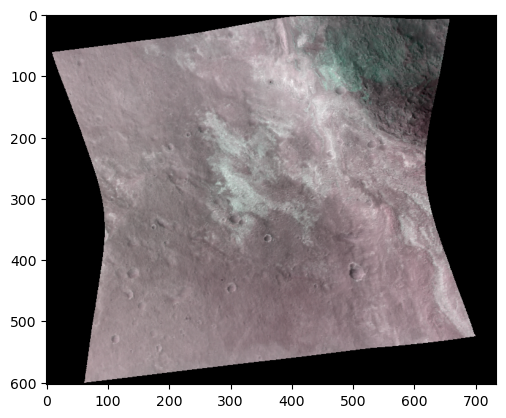

In [11]:
input_img = createInputImage("../../mars/CRISM/CRISM/Nereidum/mrocr_4001/mtrdr/2007/2007_168/frt0000643d/frt0000643d_07_if164j_mtr3.hdr")
plt.imshow(input_img)

/tmp/ipykernel_3517198/248911338.py:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img_cropped.resize(desired_size, Image.ANTIALIAS)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of spectral data cube:  (603, 734, 60)
<class 'spectral.image.ImageArray'>


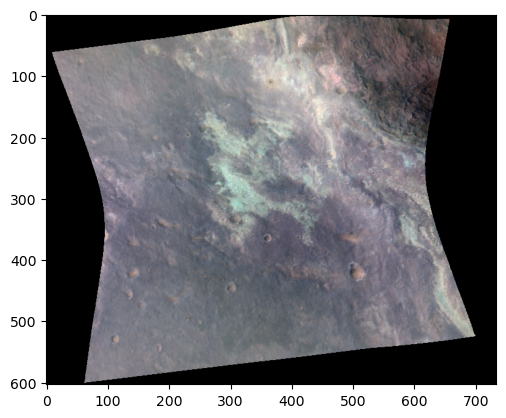

In [14]:
output_img = createOutputImage("../../mars/CRISM/CRISM/Nereidum/mrocr_4001/mtrdr/2007/2007_168/frt0000643d/frt0000643d_07_sr164j_mtr3.hdr")
plt.imshow(output_img)

## Creating Blu Pan Nir Dataset

In [16]:
def createInputImageBPN(path):
    # read CRISM spectral cube
    filename_hdr = path
    #read hdr file

    #import datasets
    img = envi.open(filename_hdr)

    #wavelength
    wavelength = np.array(list(map(int,img.bands.centers)))
    print("Number of Bands: " , wavelength.shape[0])

    #load spectral data as image.array.
    data_spectral = img.load()
    print("Shape of spectral data cube: ", data_spectral.shape)

    assert wavelength.shape[0]==data_spectral.shape[2]
    print(type(data_spectral))
    arr = np.array(data_spectral)
    print(type(arr))
    image_size = data_spectral.shape[0]*data_spectral.shape[1]
    image_width = data_spectral.shape[0]
    image_height = data_spectral.shape[1]

    # show band 40 of spectral cube
    slice_data = arr[:,:,40]

    slice_data[slice_data==65535]=np.nan

    # apply filters on CRISM spectral cube to convert it to CaSSIS 4 features (red,blue,pan,nir)

    images_products = pd.DataFrame(data=np.zeros((image_size,4)),columns =("cassis_blue","cassis_pan",
                                                                          "cassis_nir","cassis_red") )
    spectra_cube = pd.DataFrame(data=np.reshape(arr,(image_size,-1)),columns=wavelength)


    filter1=[]
    filter2=[]
    filter3=[]
    filter4=[]
    wavelengths =Response_filters["wavelength"]
    for columns in spectra_cube.columns:
        wv = float((int(float((columns)))))
        if wv<1101:
            pos= wavelengths[wavelengths == wv].index[0]
            filter1.append(Response_filters.loc[pos,"blue"])
            filter2.append(Response_filters.loc[pos,"pan"])
            filter3.append(Response_filters.loc[pos,"nir"])
            filter4.append(Response_filters.loc[pos,"red"])
        else:
            filter1.append(0.0)
            filter2.append(0.0)
            filter3.append(0.0)
            filter4.append(0.0)
    i=0
    for iter, rows in spectra_cube.iterrows():
         images_products.at[i,"cassis_blue"] = rows.dot(filter1)
         images_products.at[i,"cassis_pan"] = rows.dot(filter2)
         images_products.at[i,"cassis_nir"] = rows.dot(filter3)
         images_products.at[i,"cassis_red"] = rows.dot(filter4)
         i=i+1
    images_products

    # show features
    nir_channel = images_products["cassis_nir"].to_numpy().reshape((image_width,image_height))
    red_channel = images_products["cassis_red"].to_numpy().reshape((image_width,image_height))
    blue_channel = images_products["cassis_blue"].to_numpy().reshape((image_width,image_height))
    pan_channel = images_products["cassis_pan"].to_numpy().reshape((image_width,image_height))
    nir_channel[nir_channel>=65535]=np.nan

    cassis = np.dstack((blue_channel,pan_channel,nir_channel))


    for i in range(0,3):
        cassis[:,:,i] = (cassis[:,:,i]-np.nanmin(cassis[:,:,i]))/(np.nanmax(cassis[:,:,i])-np.nanmin(cassis[:,:,i]))
    cassis = cassis *255.0
    cassis = cassis.astype(int)
    print(cassis.shape)
    return cassis
    


Number of Bands:  489
Shape of spectral data cube:  (603, 734, 489)
<class 'spectral.image.ImageArray'>
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(603, 734, 3)


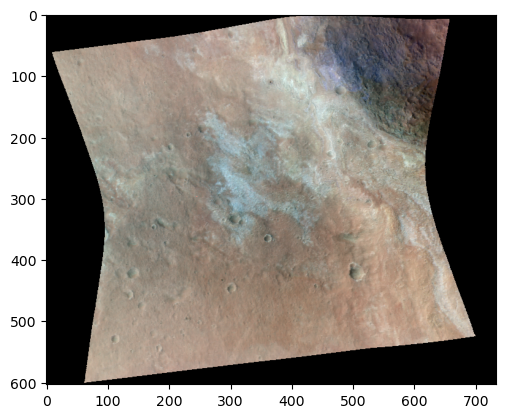

In [17]:
input_img = createInputImageBPN("../../mars/CRISM/CRISM/Nereidum/mrocr_4001/mtrdr/2007/2007_168/frt0000643d/frt0000643d_07_if164j_mtr3.hdr")
plt.imshow(input_img)

## Creating PCA Image

In [32]:
def apply_pca(image):
    # loaded_image = Image.open("4channelimg_output.png")
    # #Convert the loaded image back to a NumPy array
    # image = np.array(loaded_image)
    print(image.shape)
    image = Image.fromarray(image.astype(np.uint8))
    image = np.array(image)

    original_shape = image.shape
    flattened_image = image.reshape((-1, 4))

    # Apply PCA to the flattened image
    pca = PCA(n_components=3)
    reduced_image = pca.fit_transform(flattened_image)

    # Reshape the reduced image back to the original shape
    reduced_image = reduced_image.reshape(*original_shape[:-1])

    print(reduced_image.shape)
    return reduced_image

def apply_pca_array(image):
    # loaded_image = Image.open("4channelimg_output.png")
    # #Convert the loaded image back to a NumPy array
    # image = np.array(loaded_image)
    print(image.shape)
    image = Image.fromarray(image.astype(np.uint8))
    image = np.array(image)

    original_shape = image.shape
    flattened_image = image.reshape((-1, 4))

    # Apply PCA to the flattened image
    pca = PCA(n_components=3)
    reduced_image = pca.fit_transform(flattened_image)

    # Reshape the reduced image back to the original shape
    reduced_image = reduced_image.reshape(original_shape[:-1] + (3,))

    print(reduced_image.shape)
    return reduced_image

In [21]:
def createInputImage4ch(path):
    # read CRISM spectral cube
    filename_hdr = path
    #read hdr file

    #import datasets
    img = envi.open(filename_hdr)

    #wavelength
    wavelength = np.array(list(map(int,img.bands.centers)))
    print("Number of Bands: " , wavelength.shape[0])

    #load spectral data as image.array.
    data_spectral = img.load()
    print("Shape of spectral data cube: ", data_spectral.shape)

    assert wavelength.shape[0]==data_spectral.shape[2]
    print(type(data_spectral))
    arr = np.array(data_spectral)
    print(type(arr))
    image_size = data_spectral.shape[0]*data_spectral.shape[1]
    image_width = data_spectral.shape[0]
    image_height = data_spectral.shape[1]

    # show band 40 of spectral cube
    slice_data = arr[:,:,40]

    slice_data[slice_data==65535]=np.nan

    # apply filters on CRISM spectral cube to convert it to CaSSIS 4 features (red,blue,pan,nir)

    images_products = pd.DataFrame(data=np.zeros((image_size,4)),columns =("cassis_blue","cassis_pan",
                                                                          "cassis_nir","cassis_red") )
    spectra_cube = pd.DataFrame(data=np.reshape(arr,(image_size,-1)),columns=wavelength)


    filter1=[]
    filter2=[]
    filter3=[]
    filter4=[]
    wavelengths =Response_filters["wavelength"]
    for columns in spectra_cube.columns:
        wv = float((int(float((columns)))))
        if wv<1101:
            pos= wavelengths[wavelengths == wv].index[0]
            filter1.append(Response_filters.loc[pos,"blue"])
            filter2.append(Response_filters.loc[pos,"pan"])
            filter3.append(Response_filters.loc[pos,"nir"])
            filter4.append(Response_filters.loc[pos,"red"])
        else:
            filter1.append(0.0)
            filter2.append(0.0)
            filter3.append(0.0)
            filter4.append(0.0)
    i=0
    for iter, rows in spectra_cube.iterrows():
         images_products.at[i,"cassis_blue"] = rows.dot(filter1)
         images_products.at[i,"cassis_pan"] = rows.dot(filter2)
         images_products.at[i,"cassis_nir"] = rows.dot(filter3)
         images_products.at[i,"cassis_red"] = rows.dot(filter4)
         i=i+1
    images_products

    # show features
    nir_channel = images_products["cassis_nir"].to_numpy().reshape((image_width,image_height))
    red_channel = images_products["cassis_red"].to_numpy().reshape((image_width,image_height))
    blue_channel = images_products["cassis_blue"].to_numpy().reshape((image_width,image_height))
    pan_channel = images_products["cassis_pan"].to_numpy().reshape((image_width,image_height))
    nir_channel[nir_channel>=65535]=np.nan

    cassis = np.dstack((blue_channel,pan_channel,nir_channel,red_channel))


    for i in range(0,3):
        cassis[:,:,i] = (cassis[:,:,i]-np.nanmin(cassis[:,:,i]))/(np.nanmax(cassis[:,:,i])-np.nanmin(cassis[:,:,i]))
    cassis = cassis *255.0
    cassis = cassis.astype(int)
    print(cassis.shape)
    # X= images_products.to_numpy().reshape((image_width*image_height,-1))
    return cassis
    


In [22]:
input_img = createInputImage4ch("../../mars/CRISM/CRISM/Nereidum/mrocr_4001/mtrdr/2007/2007_168/frt0000643d/frt0000643d_07_if164j_mtr3.hdr")
print(input_img.shape)

Number of Bands:  489
Shape of spectral data cube:  (603, 734, 489)
<class 'spectral.image.ImageArray'>
<class 'numpy.ndarray'>
(603, 734, 4)
(603, 734, 4)


(603, 734, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(603, 734, 3)


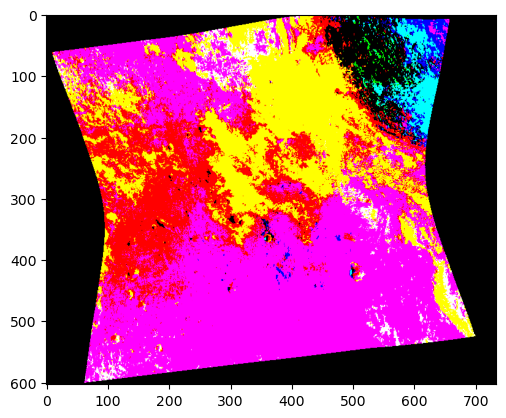

In [33]:
featuret = apply_pca_array(input_img)
featuret.shape
plt.imshow(featuret)

## Creating Dataset using rectangular filter

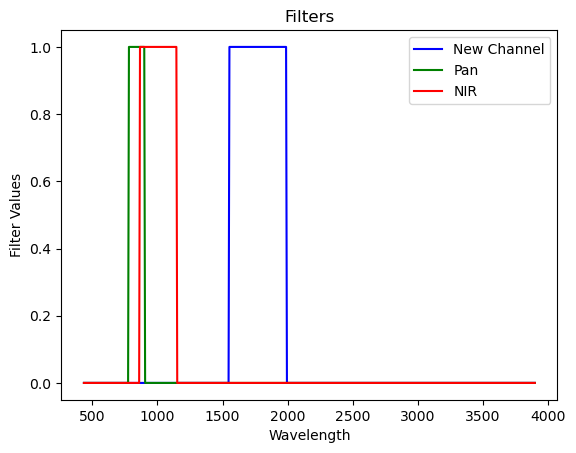

In [78]:
#Load crism bands
cube_bands = np.load("../CRISM_bands.npy")
wavelength = cube_bands
print("Number of Bands: " , wavelength.shape[0])

x = wavelength

new_channel = np.where(np.logical_and(x <= 1990 , x >= 1550), 1, 0)
pan = np.where(np.logical_and(x <= 900 , x >= 780), 1, 0)
nir = np.where(np.logical_and(x <= 1150 , x >= 860), 1, 0)
all_filters = np.vstack((pan, nir, new_channel))

plt.plot(x, new_channel, label='New Channel', color='blue')
plt.plot(x, pan, label='Pan', color='green')
plt.plot(x, nir, label='NIR', color='red')

plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Filter Values')
plt.title('Filters')

plt.show()


In [46]:
def createInputImageRect(path):
    
    filename_hdr = path
    #read hdr file

    #import datasets
    img = envi.open(filename_hdr)
    
    #wavelength
    #wavelength = np.array(list(map(int,img.bands.centers)))
    #print("Number of Bands: " , wavelength.shape[0])

    #load spectral data as image.array.
    data_spectral = img.load()
    print("Shape of spectral data cube: ", data_spectral.shape)

    #assert wavelength.shape[0]==data_spectral.shape[2]
    print(type(data_spectral))
    cube = np.array(data_spectral)
    print(type(cube))

    image_size = data_spectral.shape[0]*data_spectral.shape[1]
    image_width = data_spectral.shape[0]
    image_height = data_spectral.shape[1]

    summary_products_bands = np.load("../CRISM_bands_products.npy")
    cube_bands = np.load("../CRISM_bands.npy")

    #wavelength and data shape
    wavelength = cube_bands
    print("Number of Bands: " , wavelength.shape[0])

    #load spectral data as image.array.
    data_spectral = cube
    print("Shape of spectral data cube: ", data_spectral.shape)
    #assert wavelength.shape[0]==data_spectral.shape[2]

    image_size = data_spectral.shape[0]*data_spectral.shape[1]
    image_width = data_spectral.shape[0]
    image_height = data_spectral.shape[1]

    # replace default mask with nan pl note nan are problematic for
    data_spectral[data_spectral==65535]=np.nan
    # display CaSSIS like filter
    x = wavelength

    filter1 = np.where(np.logical_and(x<=1550 , x>=1990), 1, 0)
    filter2 = np.where(np.logical_and(x<=810 , x>=550), 1, 0)
    filter3 = np.where(np.logical_and(x<=900 , x>=780), 1, 0)
    filter4 = np.where(np.logical_and(x<=1150 , x>=860), 1, 0)
    all_filters = np.vstack((filter1,filter2,filter3,filter4))

    images_products = pd.DataFrame(data=np.zeros((image_size,4)),columns =("cassis_blue","cassis_pan",
                                                                           "cassis_nir","cassis_red") )
    data_spectral = data_spectral.reshape((image_size,-1))
    print(data_spectral.shape)
    # 400-570,- 500-810m,780-900nm 850-1150
    images_products["new_channel"] = np.sum(data_spectral[:, find_nearest(wavelength,1550):find_nearest(wavelength,1990)],axis=1)/(1990-1550)
    images_products["cassis_red"] =  np.sum(data_spectral[:, find_nearest(wavelength,550): find_nearest(wavelength,810)],axis=1)/(810-550)
    images_products["cassis_pan"] =  np.sum(data_spectral[:, find_nearest(wavelength,780): find_nearest(wavelength,900)],axis=1)/(900-780)
    images_products["cassis_nir"] =  np.sum(data_spectral[:, find_nearest(wavelength,860): find_nearest(wavelength,1150)],axis=1)/(1150-860)

    # create and sho show  CaSSIS like features
    nir_channel = images_products["cassis_nir"].to_numpy().reshape((image_width,image_height))
    red_channel = images_products["cassis_red"].to_numpy().reshape((image_width,image_height))
    new_channel = images_products["new_channel"].to_numpy().reshape((image_width,image_height))
    pan_channel = images_products["cassis_pan"].to_numpy().reshape((image_width,image_height))

    cassis = np.dstack((pan_channel,nir_channel,new_channel))
    
    for i in range(0,3):
        cassis[:,:,i] = (cassis[:,:,i]-np.nanmin(cassis[:,:,i]))/(np.nanmax(cassis[:,:,i])-np.nanmin(cassis[:,:,i]))
    
    cassis = cassis *255.0
    cassis = cassis.astype(int)
    
    return cassis

Shape of spectral data cube:  (603, 734, 489)
<class 'spectral.image.ImageArray'>
<class 'numpy.ndarray'>
Number of Bands:  489
Shape of spectral data cube:  (603, 734, 489)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(442602, 489)


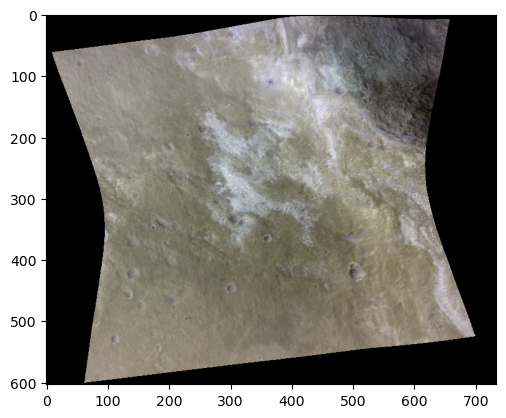

In [27]:
input_img = createInputImageRect("../../mars/CRISM/CRISM/Nereidum/mrocr_4001/mtrdr/2007/2007_168/frt0000643d/frt0000643d_07_if164j_mtr3.hdr")
plt.imshow(input_img)

# Augmenting the dataset

In [38]:
def divide_image(image):
    # Get the shape of the image
    height, width, _ = image.shape

    # Calculate the midpoints
    mid_height = height // 2
    mid_width = width // 2

    # Divide the image into 4 equal parts
    top_left = image[:mid_height, :mid_width]
    top_right = image[:mid_height, mid_width:]
    bottom_left = image[mid_height:, :mid_width]
    bottom_right = image[mid_height:, mid_width:]

    # Convert numpy arrays to PIL Images, convert to RGB, and resize
    desired_size = (512, 512)
    top_left = Image.fromarray(top_left.astype(np.uint8)).convert("RGB").resize(desired_size)
    top_right = Image.fromarray(top_right.astype(np.uint8)).convert("RGB").resize(desired_size)
    bottom_left = Image.fromarray(bottom_left.astype(np.uint8)).convert("RGB").resize(desired_size)
    bottom_right = Image.fromarray(bottom_right.astype(np.uint8)).convert("RGB").resize(desired_size)

    return top_left, top_right, bottom_left, bottom_right

def plot_images(parts):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].imshow(parts[0])
    axs[0, 0].set_title('Top Left')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(parts[1])
    axs[0, 1].set_title('Top Right')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(parts[2])
    axs[1, 0].set_title('Bottom Left')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(parts[3])
    axs[1, 1].set_title('Bottom Right')
    axs[1, 1].axis('off')
    plt.show()


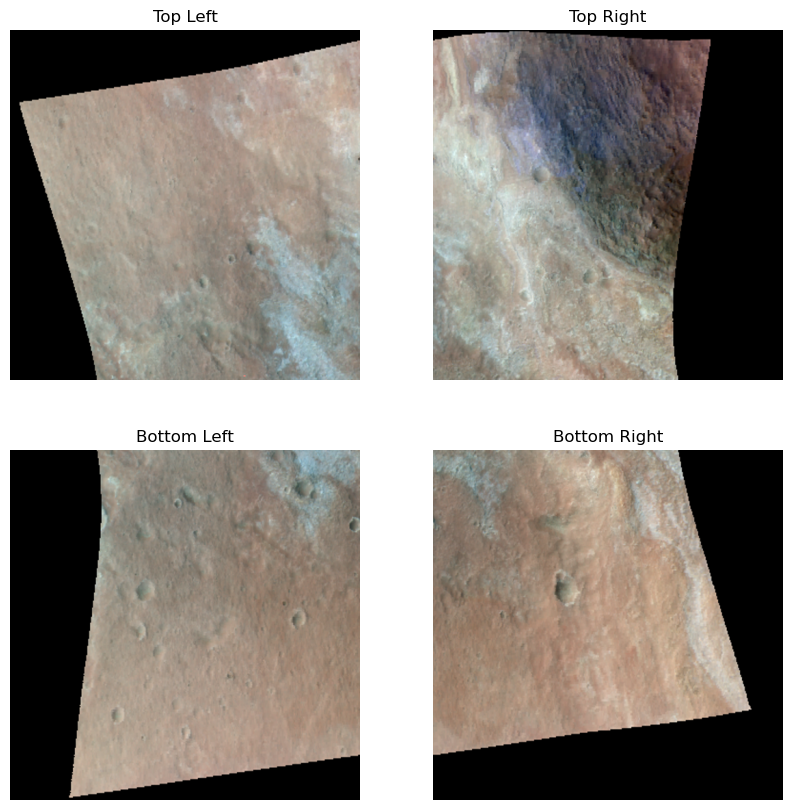

In [40]:
input_img_pnr = createInputImage("../../mars/CRISM/CRISM/Nereidum/mrocr_4001/mtrdr/2007/2007_168/frt0000643d/frt0000643d_07_if164j_mtr3.hdr")
parts = divide_image(input_img_pnr)
plot_images(parts)

# Creating Metadata to add

In [42]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# Function to parse KML file and extract required information
# Function to parse KML file and extract required information
def parse_kml(file_path):
    # Parse the KML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Define the KML namespace
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}

    # Find the Placemark element
    placemark = root.find('.//kml:Placemark', ns)
    filename = os.path.basename(file_path)
    name = filename[:11]
    print('placemark ', placemark)

    # Extract the longitude, latitude, and altitude
    look_at = placemark.find('kml:LookAt', ns)
    longitude = look_at.find('kml:longitude', ns).text
    latitude = look_at.find('kml:latitude', ns).text
    altitude = look_at.find('kml:altitude', ns).text

    # Extract the coordinates
    coordinates = placemark.find('.//kml:coordinates', ns).text
    print(longitude,latitude,altitude,coordinates)

    return name, longitude, latitude, altitude, coordinates


# Function to find the KML file for a given HDR file
def find_kml_file(root_directory, hdr_filename):
    prefix = hdr_filename[:11]
    print('prefix ', prefix)

    for foldername, subfolders, filenames in os.walk(root_directory):
        for filename in filenames:
            if filename.startswith(prefix) and filename.endswith(".kml"):
                print('derkml file ', os.path.join(foldername, filename))
                return os.path.join(foldername, filename)

    return None

# Function to process HDR files and create a DataFrame
def process_hdr_files(hdr_paths, root_directory):
    data = []

    for hdr_path in hdr_paths:
        hdr_filename = os.path.basename(hdr_path)

        kml_path = find_kml_file(root_directory, hdr_filename)

        if kml_path:
            name, latitude, longitude, altitude, coordinates = parse_kml(kml_path)

            if name is not None and latitude is not None and longitude is not None and altitude is not None and coordinates is not None:
                # Extracting information from HDR file
                relative_folder = os.path.relpath(os.path.dirname(kml_path), root_directory)
                first_folder = relative_folder.split(os.path.sep)[0]

                # Creating a dictionary for each entry
                entry = {
                    "Name": name,
                    "Latitude": latitude,
                    "Longitude": longitude,
                    "Altitude": altitude,
                    "Coordinates": coordinates,
                    "Location_name": first_folder,
                }

                data.append(entry)

    # Creating a Pandas DataFrame
    df = pd.DataFrame(data)
    return df



In [ ]:
# Example usage
# hdr_paths = ["/path/to/hdr/file1.hdr", "/path/to/hdr/file2.hdr"]  # Add your HDR file paths
# if_paths = ['../mars/CRISM/CRISM/coprates/MROCR_4001/mtrdr/2006/2006_353/hrl00003752/hrl00003752_07_if182j_mtr3.hdr', '../mars/CRISM/CRISM/coprates/MROCR_4001/mtrdr/2007/2007_002/hrs00003b3c/hrs00003b3c_07_if173j_mtr3.hdr']

root_directory = "../../mars/CRISM/CRISM"

result_df = process_hdr_files(if_paths, root_directory)


In [45]:
result_df.to_csv('metadata.csv', index=False)
result_df = pd.read_csv('../metadata.csv')
result_df

,Name,Latitude,Longitude,Altitude,Coordinates,Location_name
0,hrl00003752,-68.8154,-10.2051,1000000.0,"\n -68.8154,-10.2051,100\n",coprates
1,hrs00003b3c,-55.8248,-14.4447,1000000.0,"\n -55.8248,-14.4447,100\n",coprates
2,hrs00004787,-59.7881,-13.2383,1000000.0,"\n -59.7881,-13.2383,100\n",coprates
3,frt00005f84,-60.3211,-13.5780,1000000.0,"\n -60.3211,-13.578,100\n",coprates
4,frt000061f3,-68.9172,-12.1886,1000000.0,"\n -68.9172,-12.1886,100\n",coprates
...,...,...,...,...,...,...
122,frt0001ecba,-77.5800,-18.3600,1000000.0,"-18.38,-77.58",jezero crater
123,frt0001fb74,-77.5800,-18.3600,1000000.0,"-18.38,-77.58",jezero crater
124,frt0001fb74,-77.5800,-18.3600,1000000.0,"-18.38,-77.58",jezero crater
125,frt00021da6,-77.5800,-18.3600,1000000.0,"-18.38,-77.58",jezero crater


# Creating Dataset

## Finding paths

In [ ]:
def find_files_with_keywords_and_extension(root_path, keywords, extension):
    if_paths = []
    sr_paths = []
    
    skip_folder = '../../mars/CRISM/CRISM/vorversuche/frt0000b385'

    for foldername, subfolders, filenames in os.walk(root_path):
        if skip_folder and skip_folder in foldername:
            continue
        for filename in filenames:
            if filename.lower().endswith(extension):
                file_path = os.path.join(foldername, filename)
                if any(keyword in filename.lower() for keyword in keywords[0]):
                    if_paths.append(file_path)
                elif any(keyword in filename.lower() for keyword in keywords[1]):
                    sr_paths.append(file_path)

    return if_paths, sr_paths


root_path = '../../mars/CRISM/CRISM'
keywords = (['if'], ['sr'])
extension = '.hdr'

if_paths, sr_paths = find_files_with_keywords_and_extension(root_path, keywords, extension)


Update the create input image according to the desired type of dataset ( rgb, pnr,pca)

In [ ]:
def find_corresponding_sr_path(if_path, sr_paths):
    if_folder = os.path.basename(os.path.dirname(if_path))
    for sr_path in sr_paths:
        sr_folder = os.path.basename(os.path.dirname(sr_path))
        if if_folder == sr_folder:
            return sr_path
    return None

# Updated process_files function
coount = 0
def process_files(if_paths):
    count = 0
    for if_path in if_paths:
        parent_folder = os.path.basename(os.path.dirname(if_path))
        new_folder_path = os.path.join('crism_dataset_extended_pnr', parent_folder)
        os.makedirs(new_folder_path, exist_ok=True)

        input_img = createInputImage(if_path)
        # input_img = apply_pca(input_img)
        input_parts = divide_image(input_img)
        print(new_folder_path)
                # Save the full images with fixed names
        Image.fromarray(input_img.astype(np.uint8)).resize((512,512)).save(os.path.join(new_folder_path, 'original_image.png'))

        

        sr_path = find_corresponding_sr_path(if_path, sr_paths)
        if sr_path:
            output_img = createOutputImage(sr_path)
            output_parts = divide_image(output_img)
            Image.fromarray(output_img.astype(np.uint8)).resize((512,512)).save(os.path.join(new_folder_path, 'edited_image.png'))
            print(if_path,sr_path)
            
            for i, part in enumerate(input_parts, start=1):
                part_folder = f'{new_folder_path}_{i}'
                os.makedirs(part_folder, exist_ok=True)
                part.save(os.path.join(part_folder, 'original_image.png'))

            for i, part in enumerate(output_parts, start=1):
                part_folder = f'{new_folder_path}_{i}'
                os.makedirs(part_folder, exist_ok=True)
                part.save(os.path.join(part_folder, 'edited_image.png'))
            
            count = count +1

In [ ]:
process_files(if_paths)